In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.chdir("..")
from src.kernel_trader_general import *
from src.kernel_compute_general import *
from src import Ito_SigKer
from src.utils import *
from src.simulators import *
from src.alpha_decay import *
import yfinance as yf


if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cpu


# First Model

## Data Creation

$$X_t = X_t$$
$$Y_t = X_t + Z_t$$

with $X_t$ a 0-drift GBM and Z a 0-mean OU process.


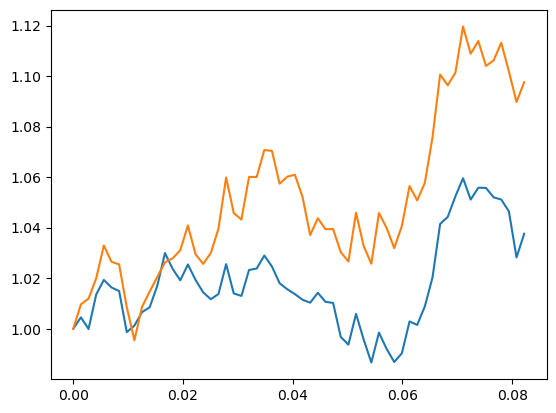

In [2]:
#torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 200, 100, 60, 1
sigma, S0, T = 0.2, 1.0, 30./365 # Black-Scholes parameters
theta, mu, std = 2, 0.0, .15


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d, 2)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW[..., 0].cumsum(dim=1)), dim = 1)

X = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

Z = torch.zeros(X.shape).to(X.device.type)
for t in range(Z.shape[1]-1):
    Z[:, t+1, :] = Z[:, t, :] - theta*(mu - Z[:, t, :])*dt + std*dW[:, t, :, -1]


paths = torch.cat([X, X+Z], dim=-1)
train_paths = paths[:batch_x]
test_paths = paths[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), train_paths[0].detach().cpu())
plt.show()

In [5]:
augment_with_time(train_paths, T).shape
temp = torch.cat([train_paths[:,1:], torch.zeros((train_paths.shape[0], 1, train_paths.shape[-1]))], dim=1)
temp.shape

torch.Size([200, 60, 2])

## Model Instantiation

In [6]:
import sigkernel

class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        self.dxi = 2
        
    def compute_Gram(self, features_X, features_Y, sym=False):
        temp = self.Kernel_Class.compute_Gram(self.scale*features_X.double(),self.scale*features_Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order] 
        return temp.unsqueeze(-1).unsqueeze(-1)*torch.eye(self.dxi).unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        # Bx, By = features_X.shape[0], features_Y.shape[0]
        # T = features_X.shape[1]
        # return torch.zeros((Bx, By, T, T, self.dxi, self.dxi)).double()
    
    def K_Phi(self, market_X, features_X, max_batch=50):
        return super().K_Phi(market_X, features_X, max_batch)

In [112]:
Ker = SigKer()
feature_fn = lambda paths: augment_with_time(paths, T)
# feature_fn = lambda paths: paths
# feature_fn = lambda paths:  torch.cat([paths.diff(dim=1), torch.zeros((paths.shape[0], 1, paths.shape[-1]))], dim=1)
# feature_fn = lambda paths: torch.cat([paths[:,1:], torch.zeros((paths.shape[0], 1, paths.shape[-1]))], dim=1)
# feature_fn = lambda paths: torch.zeros(paths.size())
market_fn =  lambda paths: paths


sk_trade = KernelTrader(Ker, feature_fn, market_fn, device='cpu')
sk_trade.pre_fit(train_paths)

tensor(0.0390, dtype=torch.float64)


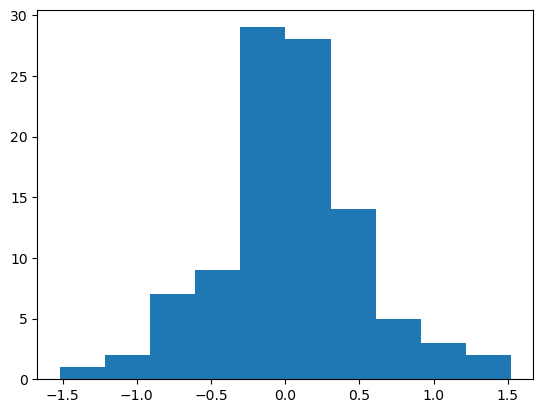

In [113]:
sk_trade.fit(risk_aversion=0.5,  regularisation=2e-7)
sk_trade.compute_pnl(test_paths, Phi_precomputed=False)
plt.hist(sk_trade.pnl[:,-1])
print(sk_trade.pnl[:,-1].mean())

In [114]:
sk_trade.Xi.mean()

tensor(7.5245e-08, dtype=torch.float64)

In [115]:
(0.5/2e-7)*sk_trade.Xi.mean()

tensor(0.1881, dtype=torch.float64)

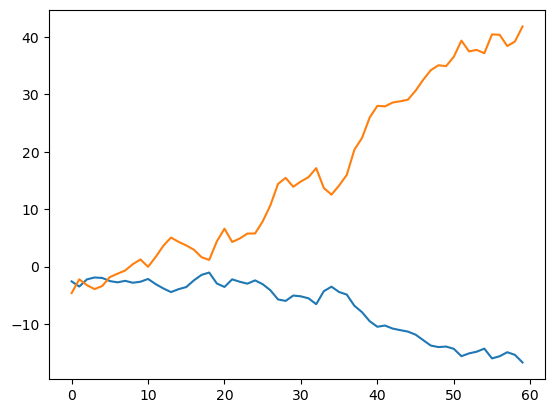

In [116]:
plt.plot(sk_trade.position[0])
plt.show()

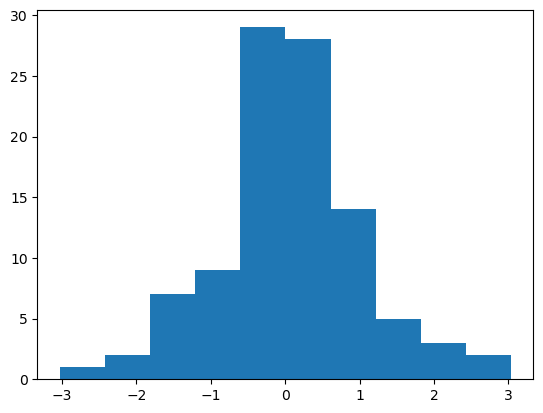

tensor(0.0778, dtype=torch.float64)


In [117]:
# Sharpe Ratios
plt.hist(sk_trade.pnl[:,-1]/sk_trade.pnl[:,-1].std(dim=0))
plt.show()

print(sk_trade.pnl[:, -1].mean()/sk_trade.pnl[:, -1].std())

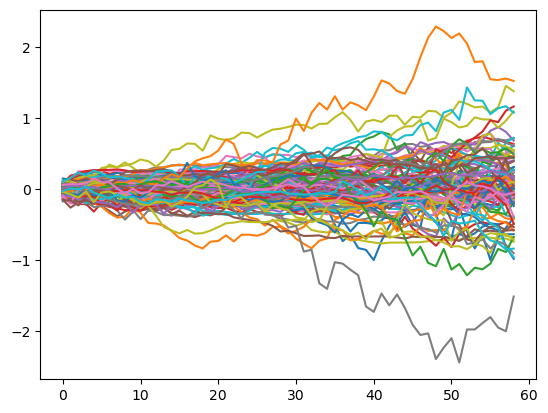

In [118]:
plt.plot(sk_trade.pnl.T)
plt.show()

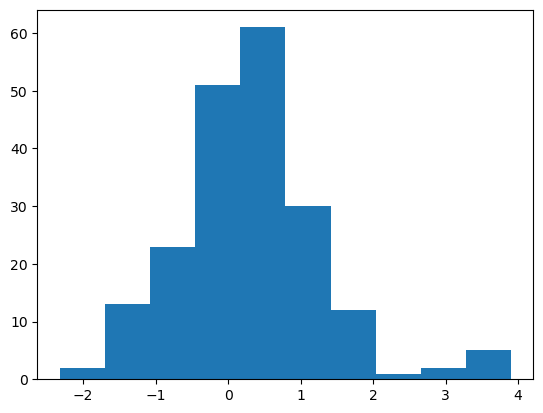

tensor(0.3071, dtype=torch.float64)


In [119]:
sk_trade.compute_pnl(train_paths, Phi_precomputed=False)

# Sharpe Ratios
plt.hist(sk_trade.pnl[:,-1]/sk_trade.pnl[:,-1].std(dim=0))
plt.show()

print(sk_trade.pnl[:, -1].mean()/sk_trade.pnl[:, -1].std())

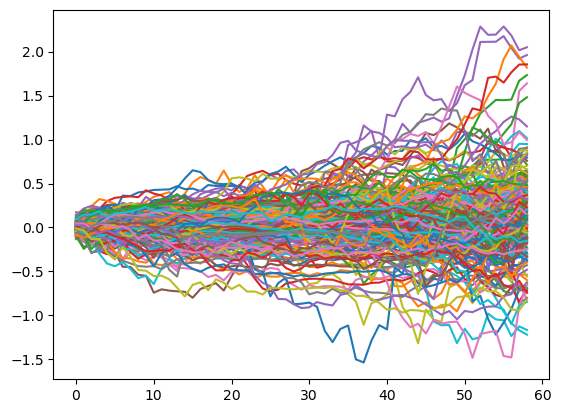

In [120]:
plt.plot(sk_trade.pnl.T)
plt.show()